In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import KFold
from scipy.io.arff import loadarff
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix, diags

In [3]:
np.random.seed(42)

## Optimization algorithms implementation

In [4]:
class LogisticRegression():
    def __init__(self, generate_interactions):
        self.coef = None
        self.generate_interactions = generate_interactions
        self.loglikes = []
    
    
    def _generate_interactions(self, X):
        new_variables = []
        for i in range(X.shape[-1]):
            for j in range(i+1, X.shape[-1]):
                new_variables.append(X[:, i] * X[:, j])
        new_variables = np.array(new_variables).T
        return np.hstack((X, new_variables))
    
    
    def _early_stopping(self, epochs):
        if len(self.loglikes) < epochs:
            return False
        
        return (abs(np.array(self.loglikes)[-epochs:] - self.loglikes[-epochs]) <= 1e-4).all()
    
    def train(self, X, y, epoch_num):
        pass
            

    def predict(self, X):
        if self.generate_interactions:
            X = self._generate_interactions(X)
        X = np.hstack((np.ones((len(X), 1)), X))    

        return (1 / (1 + np.exp(-X @ self.coef)) > 0.5).astype(int)
        

In [5]:
class IWLS(LogisticRegression):
    def __init__(self, generate_interactions=False):
        super().__init__(generate_interactions=generate_interactions)

        
    def train(self, X, y, epoch_num, epoch_with_no_improvement=10):
        if self.generate_interactions:
            X = self._generate_interactions(X)
        
        X = np.hstack((np.ones((len(X), 1)), X))
#         self.coef = np.random.normal(0, 0.25, X.shape[-1])
        self.coef = np.array([0] * X.shape[-1])
        best_coef = self.coef
        best_loglike = -np.inf
        p = 1 / (1 + np.exp(-X @ self.coef))
        for i in range(epoch_num):
            W = diags(p * (1 - p), 0)
            z = (X @ self.coef + np.reshape((y - p), (1, -1)) @ diags(1 / (p * (1 - p)), 0)).flatten()
            self.coef = np.linalg.inv(X.T @ W @ X) @ X.T @ W @ z
            
            p = 1 / (1 + np.exp(-X @ self.coef)) # for next iteration and calculating loglike
            # stops log from producing errors by shifting p values away from 0 and 1
            p_smoothing = 0.001 * (p < 0.001).astype('int') - 0.001 * (p > 0.999).astype('int')
            p = p + p_smoothing
            loglike = (y @ np.log(p) + (1 - y) @ np.log(1 - p)) / len(X)
            if loglike > best_loglike:
                best_coef = self.coef
                best_loglike = loglike
            self.loglikes.append(loglike)
            
            print(f'IWLS Epoch {i+1}/{epoch_num} - loss: {-loglike}')
            
            if self._early_stopping(epoch_with_no_improvement):
                self.coef = best_coef
                print('Early stopping')
                break

In [6]:
class SGD(LogisticRegression):
    def __init__(self, generate_interactions=False):
        super().__init__(generate_interactions=generate_interactions)
        
    
    def train(self, X, y, epoch_num, lr=0.01, epoch_with_no_improvement=10):
        if self.generate_interactions:
            X = self._generate_interactions(X)
        X = np.hstack((np.ones((len(X), 1)), X))
        coef = np.random.normal(0, 0.25, X.shape[-1])
        best_coef = coef
        best_loglike = -np.inf
        self.coef = coef
        for i in range(epoch_num):
            for j in range(len(X)):
                p_j = self.sigmoid(np.dot(coef, X[j]))
                g = X[j] * (y[j]-p_j)
                coef += lr * g
            p = self.sigmoid(np.dot(X, coef))
            # stops log from producing errors by shifting p values away from 0 and 1
            p_smoothing = 0.001 * (p < 0.001).astype('int') - 0.001 * (p > 0.999).astype('int')
            p = p + p_smoothing
            loglike = (y @ np.log(p) + (1 - y) @ np.log(1 - p)) / len(X)
            if loglike > best_loglike:
                best_coef = coef
                best_loglike = loglike
            self.loglikes.append(loglike)
            
            print(f'SGD Epoch {i+1}/{epoch_num} - loss: {-loglike}')
            
            if self._early_stopping(epoch_with_no_improvement):
                self.coef = best_coef
                print('Early stopping')
                break
        self.coef = coef

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
        

In [7]:
class ADAM(LogisticRegression):
    def __init__(self, generate_interactions=False, alpha=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-8):
        super().__init__(generate_interactions=generate_interactions)
        self.alpha = alpha
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon

    def sigmoid(self, X):
        return 1/(1 + np.exp(-X))

    def gradient(self, X, y):
        m = np.shape(X)[0]
        p = self.sigmoid(X @ self.coef)
        return (1 / m) * X.T @ (p - y)
        
    def train(self, X, y, epoch_num, epoch_with_no_improvement=10):
        if self.generate_interactions:
            X = self._generate_interactions(X)
        p = None
        N = np.shape(X)[0]
        y = y.reshape((N,1))
        X = np.hstack((np.ones((len(X), 1)), X))
        self.coef = np.zeros((np.shape(X)[1],1))
        m_t = np.zeros((np.shape(X)[1],1))
        v_t = np.zeros((np.shape(X)[1],1))
        best_coef = self.coef
        best_loglike = -np.inf
        prev_cost = -np.inf
        loglike = 0
        for i in range(1, epoch_num+1):
            p = self.sigmoid(X @ self.coef)
            p_smoothing = 0.001 * (p < 0.001).astype('int') - 0.001 * (p > 0.999).astype('int')
            cost = (1/N) * (y.T @ np.log(p) + (1-y).T @ np.log(1 - p))
            #if abs(prev_cost - loglike) < 1e-4:
            #    print('early stopping')
            #    break
            g_t = self.gradient(X, y)
            m_t = self.beta_1 * m_t + (1 - self.beta_1) * g_t
            v_t = self.beta_2 * v_t + (1 - self.beta_2) * (g_t**2)
            m_hat = m_t / (1 - self.beta_1**i)
            v_hat = v_t / (1 - self.beta_2**i)
            self.coef -= self.alpha * m_hat / (np.sqrt(v_hat) + self.epsilon)
            p = p + p_smoothing
            prev_cost = loglike
            loglike = float((y.T @ np.log(p) + (1 - y).T @ np.log(1 - p)) / len(X))
            if loglike > best_loglike:
                best_coef = self.coef
                best_loglike = loglike
            self.loglikes.append(loglike)           
            print(f'ADAM Epoch {i+1}/{epoch_num} - loss: {-loglike}')
            if self._early_stopping(epoch_with_no_improvement):
                self.coef = best_coef
                print('Early stopping')
                break

## Train test splits

In [8]:
lol_data = pd.read_csv('data_clean/lol_data.csv')
pollen_data = pd.read_csv('data_clean/pollen_data.csv')
heart_data = pd.read_csv('data_clean/heart_data.csv')
spambase_data = pd.read_csv('data_clean/spambase.csv')
ion_data = pd.read_csv('data_clean/ionosphere.csv')
phoneme_data = pd.read_csv('data_clean/phoneme.csv')
phishing_data = pd.read_csv('data_clean/phishing_websites.csv')
climate_model_data = pd.read_csv('data_clean/climate_model_simulation.csv')
banknote_data = pd.read_csv('data_clean/banknote_authentication.csv')

# zbiorek, kolumna docelowa, nazwa
datasets = [(lol_data, 'blue_win', 'LoL'), (pollen_data, 'target', 'Pollen'), (heart_data, 'output', 'Heart'), (spambase_data, 'target', 'Spam'),
            (ion_data, 'target', 'Ionosphere'), (phoneme_data, 'Class', 'Phoneme'), (phishing_data, 'Result', 'Phishing'),
            (climate_model_data, 'outcome', 'Climate'), (banknote_data, 'Class', 'Banknote')]

small_datasets = [(pollen_data, 'target', 'Pollen'), (phoneme_data, 'Class', 'Phoneme'), (banknote_data, 'Class', 'Banknote')]

MODEL_CLASSES = [IWLS, SGD, ADAM]

## Convergence analysis

In [9]:
def convergence(model_class, data, target, dataset_name):
    model = model_class()
    model.train(X, y, 500)
    loglikes = model.loglikes
    results = pd.DataFrame({'Epoch': range(1, len(loglikes)+1), 'Model': model_class.__name__, 'Dataset': dataset_name, 'Loglikes': loglikes})
    return results

In [40]:
results = []

for data, target, name in datasets:
    scaler = StandardScaler()
    X = data.drop(target, axis=1).values
    X = scaler.fit_transform(X)
    y = data[target].values
    
    for model_class in MODEL_CLASSES:
        results.append(convergence(model_class, data, target, name))

results = pd.concat(results)

IWLS Epoch 1/500 - loss: 0.47272441754338307
IWLS Epoch 2/500 - loss: 0.44550959034257415
IWLS Epoch 3/500 - loss: 0.44290120728374105
IWLS Epoch 4/500 - loss: 0.4428652225625782
IWLS Epoch 5/500 - loss: 0.4428652160496453
IWLS Epoch 6/500 - loss: 0.44286521605185086
IWLS Epoch 7/500 - loss: 0.442865216051852
IWLS Epoch 8/500 - loss: 0.4428652160518519
IWLS Epoch 9/500 - loss: 0.4428652160518519
IWLS Epoch 10/500 - loss: 0.4428652160518519
IWLS Epoch 11/500 - loss: 0.442865216051852
IWLS Epoch 12/500 - loss: 0.4428652160518519
Early stopping
SGD Epoch 1/500 - loss: 0.4459252672382444
SGD Epoch 2/500 - loss: 0.4459276502374579
SGD Epoch 3/500 - loss: 0.4459276580950711
SGD Epoch 4/500 - loss: 0.4459276581204253
SGD Epoch 5/500 - loss: 0.4459276581205071
SGD Epoch 6/500 - loss: 0.44592765812050744
SGD Epoch 7/500 - loss: 0.44592765812050733
SGD Epoch 8/500 - loss: 0.44592765812050744
SGD Epoch 9/500 - loss: 0.44592765812050733
SGD Epoch 10/500 - loss: 0.4459276581205075
Early stopping
AD

C:\Users\micha\AppData\Local\Temp\ipykernel_24700\4220366908.py:34: RuntimeWarning: divide by zero encountered in log
  cost = (1/N) * (y.T @ np.log(p) + (1-y).T @ np.log(1 - p))
C:\Users\micha\AppData\Local\Temp\ipykernel_24700\4220366908.py:34: RuntimeWarning: invalid value encountered in matmul
  cost = (1/N) * (y.T @ np.log(p) + (1-y).T @ np.log(1 - p))


ADAM Epoch 148/500 - loss: 0.23661041482477863
ADAM Epoch 149/500 - loss: 0.2364265948618396
ADAM Epoch 150/500 - loss: 0.2362451686506803
ADAM Epoch 151/500 - loss: 0.23606609784913093
ADAM Epoch 152/500 - loss: 0.23588978032779137
ADAM Epoch 153/500 - loss: 0.23571443812984078
ADAM Epoch 154/500 - loss: 0.23554112384421147
ADAM Epoch 155/500 - loss: 0.23536958481315978
ADAM Epoch 156/500 - loss: 0.23520000449377945
ADAM Epoch 157/500 - loss: 0.23503256708051812
ADAM Epoch 158/500 - loss: 0.23486702212886468
ADAM Epoch 159/500 - loss: 0.23470355522516814
ADAM Epoch 160/500 - loss: 0.2345416996242252
ADAM Epoch 161/500 - loss: 0.23438229523462303
ADAM Epoch 162/500 - loss: 0.23422400590982925
ADAM Epoch 163/500 - loss: 0.23406723747501143
ADAM Epoch 164/500 - loss: 0.23391283169023522
ADAM Epoch 165/500 - loss: 0.23375967187118768
ADAM Epoch 166/500 - loss: 0.2336081656032114
ADAM Epoch 167/500 - loss: 0.23345828568022378
ADAM Epoch 168/500 - loss: 0.23331044078996874
ADAM Epoch 169/50

C:\Users\micha\AppData\Local\Temp\ipykernel_24700\4141370605.py:21: RuntimeWarning: overflow encountered in exp
  p = 1 / (1 + np.exp(-X @ self.coef)) # for next iteration and calculating loglike


IWLS Epoch 30/500 - loss: 3.41600702977648
IWLS Epoch 31/500 - loss: 3.41600702977648
IWLS Epoch 32/500 - loss: 3.41600702977648
IWLS Epoch 33/500 - loss: 3.4032167431493527
IWLS Epoch 34/500 - loss: 3.4032167431493527
IWLS Epoch 35/500 - loss: 3.4032167431493527
IWLS Epoch 36/500 - loss: 3.4032167431493527
IWLS Epoch 37/500 - loss: 3.4160070297764795
IWLS Epoch 38/500 - loss: 3.4160070297764795
IWLS Epoch 39/500 - loss: 3.4160070297764795
IWLS Epoch 40/500 - loss: 3.4160070297764795
IWLS Epoch 41/500 - loss: 3.4160070297764795
IWLS Epoch 42/500 - loss: 3.4160070297764795
IWLS Epoch 43/500 - loss: 3.4160070297764795
IWLS Epoch 44/500 - loss: 3.4160070297764795
IWLS Epoch 45/500 - loss: 3.4032167431493527
IWLS Epoch 46/500 - loss: 3.4032167431493527
IWLS Epoch 47/500 - loss: 3.4032167431493527
IWLS Epoch 48/500 - loss: 3.4032167431493527
IWLS Epoch 49/500 - loss: 3.4032167431493527
IWLS Epoch 50/500 - loss: 3.4032167431493527
IWLS Epoch 51/500 - loss: 3.4032167431493527
IWLS Epoch 52/50

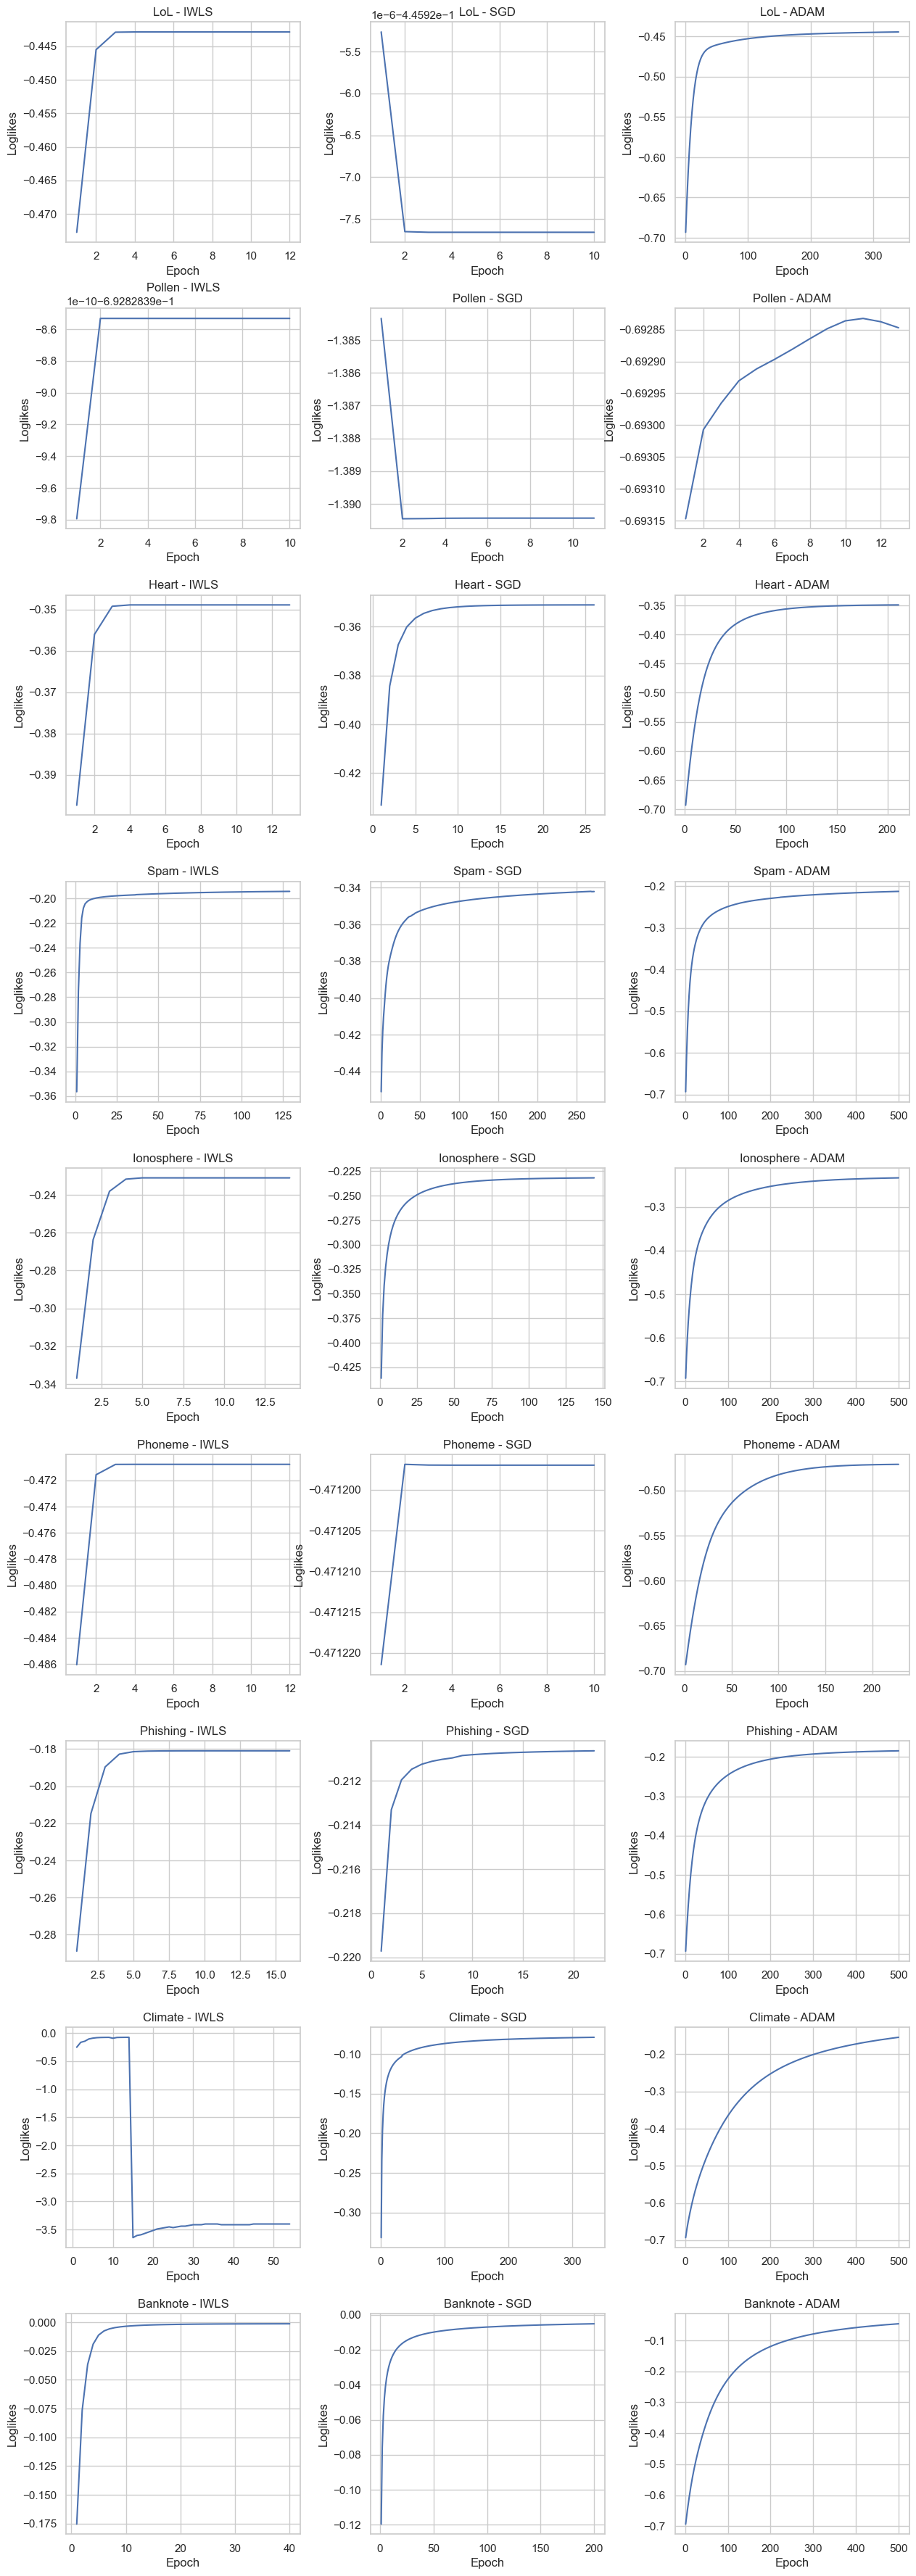

In [42]:
row_num = len(datasets)
col_num = len(MODEL_CLASSES)
fig, axs = plt.subplots(nrows=row_num, ncols=col_num, figsize=(5*col_num, 5*row_num))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
for i in range(row_num):
    dataset_name = datasets[i][2]
    for j in range(col_num):
        model_name = MODEL_CLASSES[j].__name__
        model_results = results[(results.Model == model_name) & (results.Dataset == dataset_name)]
        sns.lineplot(data=model_results, x='Epoch', y='Loglikes', ax=axs[i][j])
        axs[i][j].title.set_text(f'{dataset_name} - {model_name}')

plt.savefig('convergence.png', format='png', bbox_inches='tight')
plt.show()
        

## Classification performance

In [12]:
def performance(model_class, data, target, dataset_name, use_fit=False, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = {'Model': [model_class.__name__] * n_splits,
               'Dataset': [dataset_name] * n_splits,
               'Balanced_accuracy': []}
    for train_idx, test_idx in kf.split(data):
        X_train = np.array(data.drop(columns=[target]).iloc[train_idx])
        y_train = np.array(data[target].iloc[train_idx])
        X_test = np.array(data.drop(columns=[target]).iloc[test_idx])
        y_test = np.array(data[target].iloc[test_idx])
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        model = model_class()
        if use_fit:
            model.fit(X_train, y_train)
        else:
            model.train(X_train, y_train, 500)
        y_pred = model.predict(X_test)
        results['Balanced_accuracy'].append(balanced_accuracy_score(y_test, y_pred))
    
    return pd.DataFrame(results)

In [13]:
results = []

for data, target, name in datasets:    
    for model_class in MODEL_CLASSES:
        results.append(performance(model_class, data, target, name))
    
    for model_class in [QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis,
                        DecisionTreeClassifier, RandomForestClassifier]:
        results.append(performance(model_class, data, target, name, use_fit=True))

results = pd.concat(results)

IWLS Epoch 1/500 - loss: 0.47283450382497494
IWLS Epoch 2/500 - loss: 0.44549011003665967
IWLS Epoch 3/500 - loss: 0.4428496960681996
IWLS Epoch 4/500 - loss: 0.4428128521374349
IWLS Epoch 5/500 - loss: 0.4428128712230059
IWLS Epoch 6/500 - loss: 0.44281287124254504
IWLS Epoch 7/500 - loss: 0.4428128712425574
IWLS Epoch 8/500 - loss: 0.4428128712425574
IWLS Epoch 9/500 - loss: 0.4428128712425573
IWLS Epoch 10/500 - loss: 0.4428128712425574
IWLS Epoch 11/500 - loss: 0.4428128712425574
IWLS Epoch 12/500 - loss: 0.4428128712425573
Early stopping
IWLS Epoch 1/500 - loss: 0.47162894100000585
IWLS Epoch 2/500 - loss: 0.44422150644099767
IWLS Epoch 3/500 - loss: 0.44157875646727285
IWLS Epoch 4/500 - loss: 0.4415417875489264
IWLS Epoch 5/500 - loss: 0.4415417805021307
IWLS Epoch 6/500 - loss: 0.44154178050453036
IWLS Epoch 7/500 - loss: 0.44154178050453147
IWLS Epoch 8/500 - loss: 0.44154178050453163
IWLS Epoch 9/500 - loss: 0.4415417805045316
IWLS Epoch 10/500 - loss: 0.44154178050453147
IWL

C:\Users\micha\AppData\Local\Temp\ipykernel_24700\4220366908.py:34: RuntimeWarning: divide by zero encountered in log
  cost = (1/N) * (y.T @ np.log(p) + (1-y).T @ np.log(1 - p))
C:\Users\micha\AppData\Local\Temp\ipykernel_24700\4220366908.py:34: RuntimeWarning: invalid value encountered in matmul
  cost = (1/N) * (y.T @ np.log(p) + (1-y).T @ np.log(1 - p))


ADAM Epoch 201/500 - loss: 0.2325847898537496
ADAM Epoch 202/500 - loss: 0.23246950296471083
ADAM Epoch 203/500 - loss: 0.2323553665120714
ADAM Epoch 204/500 - loss: 0.23224209601733975
ADAM Epoch 205/500 - loss: 0.23212913507673347
ADAM Epoch 206/500 - loss: 0.2320170160979971
ADAM Epoch 207/500 - loss: 0.23190654384299247
ADAM Epoch 208/500 - loss: 0.23179607395055166
ADAM Epoch 209/500 - loss: 0.23168668375945303
ADAM Epoch 210/500 - loss: 0.23157781791434137
ADAM Epoch 211/500 - loss: 0.2314697377061232
ADAM Epoch 212/500 - loss: 0.23136270461462763
ADAM Epoch 213/500 - loss: 0.23125616387736123
ADAM Epoch 214/500 - loss: 0.23115037736023952
ADAM Epoch 215/500 - loss: 0.2310456071126934
ADAM Epoch 216/500 - loss: 0.23094184322167902
ADAM Epoch 217/500 - loss: 0.230838531659057
ADAM Epoch 218/500 - loss: 0.23073593501725934
ADAM Epoch 219/500 - loss: 0.2306351325014524
ADAM Epoch 220/500 - loss: 0.2305339377270557
ADAM Epoch 221/500 - loss: 0.23043424668257514
ADAM Epoch 222/500 - l

C:\Users\micha\AppData\Local\Temp\ipykernel_24700\4220366908.py:34: RuntimeWarning: divide by zero encountered in log
  cost = (1/N) * (y.T @ np.log(p) + (1-y).T @ np.log(1 - p))
C:\Users\micha\AppData\Local\Temp\ipykernel_24700\4220366908.py:34: RuntimeWarning: invalid value encountered in matmul
  cost = (1/N) * (y.T @ np.log(p) + (1-y).T @ np.log(1 - p))


ADAM Epoch 144/500 - loss: 0.23448352695316085
ADAM Epoch 145/500 - loss: 0.23429087538337898
ADAM Epoch 146/500 - loss: 0.2341001276341509
ADAM Epoch 147/500 - loss: 0.23391151197119453
ADAM Epoch 148/500 - loss: 0.23372552972848726
ADAM Epoch 149/500 - loss: 0.23354213903919047
ADAM Epoch 150/500 - loss: 0.2333610269011234
ADAM Epoch 151/500 - loss: 0.23318188121713374
ADAM Epoch 152/500 - loss: 0.23300547905038757
ADAM Epoch 153/500 - loss: 0.23283069379570043
ADAM Epoch 154/500 - loss: 0.2326585762705209
ADAM Epoch 155/500 - loss: 0.23248772943023938
ADAM Epoch 156/500 - loss: 0.23231947773683562
ADAM Epoch 157/500 - loss: 0.23215296982990158
ADAM Epoch 158/500 - loss: 0.23198871545826483
ADAM Epoch 159/500 - loss: 0.23182668093309655
ADAM Epoch 160/500 - loss: 0.2316668332735142
ADAM Epoch 161/500 - loss: 0.2315083239734109
ADAM Epoch 162/500 - loss: 0.23135112141522945
ADAM Epoch 163/500 - loss: 0.23119655499125735
ADAM Epoch 164/500 - loss: 0.23104377813931049
ADAM Epoch 165/500

C:\Users\micha\AppData\Local\Temp\ipykernel_24700\4220366908.py:34: RuntimeWarning: divide by zero encountered in log
  cost = (1/N) * (y.T @ np.log(p) + (1-y).T @ np.log(1 - p))
C:\Users\micha\AppData\Local\Temp\ipykernel_24700\4220366908.py:34: RuntimeWarning: invalid value encountered in matmul
  cost = (1/N) * (y.T @ np.log(p) + (1-y).T @ np.log(1 - p))


ADAM Epoch 181/500 - loss: 0.2320683715293837
ADAM Epoch 182/500 - loss: 0.23193663549175217
ADAM Epoch 183/500 - loss: 0.2318058523452049
ADAM Epoch 184/500 - loss: 0.23167654726169246
ADAM Epoch 185/500 - loss: 0.23154870163418542
ADAM Epoch 186/500 - loss: 0.2314220251517658
ADAM Epoch 187/500 - loss: 0.23129595579590134
ADAM Epoch 188/500 - loss: 0.2311718364024686
ADAM Epoch 189/500 - loss: 0.23104883354973896
ADAM Epoch 190/500 - loss: 0.2309261141722866
ADAM Epoch 191/500 - loss: 0.23080502210538778
ADAM Epoch 192/500 - loss: 0.2306849969774972
ADAM Epoch 193/500 - loss: 0.23056629494575456
ADAM Epoch 194/500 - loss: 0.2304478121076992
ADAM Epoch 195/500 - loss: 0.2301414382213058
ADAM Epoch 196/500 - loss: 0.2300233368194387
ADAM Epoch 197/500 - loss: 0.22990621867462704
ADAM Epoch 198/500 - loss: 0.2297903415337189
ADAM Epoch 199/500 - loss: 0.2296746030453151
ADAM Epoch 200/500 - loss: 0.22956007769695538
ADAM Epoch 201/500 - loss: 0.22944647984911443
ADAM Epoch 202/500 - los

C:\Users\micha\AppData\Local\Temp\ipykernel_24700\4220366908.py:34: RuntimeWarning: divide by zero encountered in log
  cost = (1/N) * (y.T @ np.log(p) + (1-y).T @ np.log(1 - p))
C:\Users\micha\AppData\Local\Temp\ipykernel_24700\4220366908.py:34: RuntimeWarning: invalid value encountered in matmul
  cost = (1/N) * (y.T @ np.log(p) + (1-y).T @ np.log(1 - p))


ADAM Epoch 185/500 - loss: 0.22385878041753246
ADAM Epoch 186/500 - loss: 0.2237376866157731
ADAM Epoch 187/500 - loss: 0.22361736849103056
ADAM Epoch 188/500 - loss: 0.2234988943829183
ADAM Epoch 189/500 - loss: 0.22338224469971854
ADAM Epoch 190/500 - loss: 0.22326549571701923
ADAM Epoch 191/500 - loss: 0.2231505330944722
ADAM Epoch 192/500 - loss: 0.22303652210303174
ADAM Epoch 193/500 - loss: 0.22292371664291266
ADAM Epoch 194/500 - loss: 0.22281182680391362
ADAM Epoch 195/500 - loss: 0.2227024675041507
ADAM Epoch 196/500 - loss: 0.22259480529883946
ADAM Epoch 197/500 - loss: 0.22248773498863217
ADAM Epoch 198/500 - loss: 0.2223815120859981
ADAM Epoch 199/500 - loss: 0.2222761202839332
ADAM Epoch 200/500 - loss: 0.22217099943645435
ADAM Epoch 201/500 - loss: 0.2220680383124969
ADAM Epoch 202/500 - loss: 0.22196613315916844
ADAM Epoch 203/500 - loss: 0.2218647246317629
ADAM Epoch 204/500 - loss: 0.22176434194958516
ADAM Epoch 205/500 - loss: 0.22166497042679098
ADAM Epoch 206/500 - 

C:\Users\micha\AppData\Local\Temp\ipykernel_24700\4220366908.py:34: RuntimeWarning: divide by zero encountered in log
  cost = (1/N) * (y.T @ np.log(p) + (1-y).T @ np.log(1 - p))
C:\Users\micha\AppData\Local\Temp\ipykernel_24700\4220366908.py:34: RuntimeWarning: invalid value encountered in matmul
  cost = (1/N) * (y.T @ np.log(p) + (1-y).T @ np.log(1 - p))


ADAM Epoch 400/500 - loss: 0.2132397808267627
ADAM Epoch 401/500 - loss: 0.21319843747396158
ADAM Epoch 402/500 - loss: 0.21315809622655235
ADAM Epoch 403/500 - loss: 0.21311712347911457
ADAM Epoch 404/500 - loss: 0.21307660637373996
ADAM Epoch 405/500 - loss: 0.21303627169114042
ADAM Epoch 406/500 - loss: 0.21299584622173967
ADAM Epoch 407/500 - loss: 0.2129558729849002
ADAM Epoch 408/500 - loss: 0.21291635086169206
ADAM Epoch 409/500 - loss: 0.212876734595799
ADAM Epoch 410/500 - loss: 0.21283756723297573
ADAM Epoch 411/500 - loss: 0.21279830353387194
ADAM Epoch 412/500 - loss: 0.2127592144904189
ADAM Epoch 413/500 - loss: 0.2127202990260925
ADAM Epoch 414/500 - loss: 0.2126815560752856
ADAM Epoch 415/500 - loss: 0.2126429845777247
ADAM Epoch 416/500 - loss: 0.21260431141117023
ADAM Epoch 417/500 - loss: 0.2125658076083014
ADAM Epoch 418/500 - loss: 0.21252747213492096
ADAM Epoch 419/500 - loss: 0.2124893039647788
ADAM Epoch 420/500 - loss: 0.2124515741526112
ADAM Epoch 421/500 - los

D:\micha\anaconda3\envs\python3103\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


IWLS Epoch 1/500 - loss: 0.3199016821209855
IWLS Epoch 2/500 - loss: 0.24243604551631998
IWLS Epoch 3/500 - loss: 0.21723441516699293
IWLS Epoch 4/500 - loss: 0.21071791399672907
IWLS Epoch 5/500 - loss: 0.20960005031297402
IWLS Epoch 6/500 - loss: 0.20954248859220437
IWLS Epoch 7/500 - loss: 0.20955226546339434
IWLS Epoch 8/500 - loss: 0.20955407899063166
IWLS Epoch 9/500 - loss: 0.20955435892615282
IWLS Epoch 10/500 - loss: 0.20955439957824581
IWLS Epoch 11/500 - loss: 0.20955440543642903
IWLS Epoch 12/500 - loss: 0.20955440627991656
IWLS Epoch 13/500 - loss: 0.2095544064013666
IWLS Epoch 14/500 - loss: 0.2095544064188547
Early stopping
IWLS Epoch 1/500 - loss: 0.3349405696340743
IWLS Epoch 2/500 - loss: 0.2623064214520488
IWLS Epoch 3/500 - loss: 0.2366545959184857
IWLS Epoch 4/500 - loss: 0.22953364798727285
IWLS Epoch 5/500 - loss: 0.2286558378072125
IWLS Epoch 6/500 - loss: 0.2286473089068485
IWLS Epoch 7/500 - loss: 0.22865254393420428
IWLS Epoch 8/500 - loss: 0.2286534733930443

D:\micha\anaconda3\envs\python3103\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\micha\anaconda3\envs\python3103\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\micha\anaconda3\envs\python3103\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\micha\anaconda3\envs\python3103\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\micha\anaconda3\envs\python3103\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


IWLS Epoch 1/500 - loss: 0.24986296474736497
IWLS Epoch 2/500 - loss: 0.16357409295839892
IWLS Epoch 3/500 - loss: 0.12152128097262185
IWLS Epoch 4/500 - loss: 0.11012257507977183
IWLS Epoch 5/500 - loss: 0.09032136052040539
IWLS Epoch 6/500 - loss: 0.08443596778695908
IWLS Epoch 7/500 - loss: 0.08160347587481581
IWLS Epoch 8/500 - loss: 0.08025082299487098
IWLS Epoch 9/500 - loss: 0.07968863742370376
IWLS Epoch 10/500 - loss: 0.07944442499659576
IWLS Epoch 11/500 - loss: 0.07918547413159928
IWLS Epoch 12/500 - loss: 0.07912847142689453
IWLS Epoch 13/500 - loss: 3.5183293227934946
IWLS Epoch 14/500 - loss: 3.3424628816705013
IWLS Epoch 15/500 - loss: 3.2944993068187745
IWLS Epoch 16/500 - loss: 3.2944993068187745
IWLS Epoch 17/500 - loss: 3.2944993068187745
IWLS Epoch 18/500 - loss: 3.3104871651026837
IWLS Epoch 19/500 - loss: 3.3264750233865925
IWLS Epoch 20/500 - loss: 3.3584507399544097
IWLS Epoch 21/500 - loss: 3.4064143148061357
IWLS Epoch 22/500 - loss: 3.47036574794177
IWLS Epoc

C:\Users\micha\AppData\Local\Temp\ipykernel_24700\4141370605.py:21: RuntimeWarning: overflow encountered in exp
  p = 1 / (1 + np.exp(-X @ self.coef)) # for next iteration and calculating loglike


IWLS Epoch 42/500 - loss: 3.9340136381751227
IWLS Epoch 43/500 - loss: 3.9340136381751227
IWLS Epoch 44/500 - loss: 3.9500014964590315
IWLS Epoch 45/500 - loss: 3.9340136381751227
IWLS Epoch 46/500 - loss: 3.9340136381751227
IWLS Epoch 47/500 - loss: 3.9500014964590315
IWLS Epoch 48/500 - loss: 3.9340136381751227
IWLS Epoch 49/500 - loss: 3.9340136381751227
IWLS Epoch 50/500 - loss: 3.9500014964590315
IWLS Epoch 51/500 - loss: 3.9340136381751227
IWLS Epoch 52/500 - loss: 3.9500014964590315
IWLS Epoch 53/500 - loss: 3.9340136381751227
IWLS Epoch 54/500 - loss: 3.9340136381751227
IWLS Epoch 55/500 - loss: 3.9500014964590315
IWLS Epoch 56/500 - loss: 3.9340136381751227
IWLS Epoch 57/500 - loss: 3.9340136381751227
IWLS Epoch 58/500 - loss: 3.9500014964590315
IWLS Epoch 59/500 - loss: 3.9340136381751227
IWLS Epoch 60/500 - loss: 3.9340136381751227
IWLS Epoch 61/500 - loss: 3.9500014964590315
IWLS Epoch 62/500 - loss: 3.9340136381751227
IWLS Epoch 63/500 - loss: 3.9340136381751227
IWLS Epoch

C:\Users\micha\AppData\Local\Temp\ipykernel_24700\1577246260.py:32: RuntimeWarning: overflow encountered in exp
  return (1 / (1 + np.exp(-X @ self.coef)) > 0.5).astype(int)


IWLS Epoch 1/500 - loss: 0.24333719987231686
IWLS Epoch 2/500 - loss: 0.15991076213346672
IWLS Epoch 3/500 - loss: 0.11906516570876978
IWLS Epoch 4/500 - loss: 0.09529523532499831
IWLS Epoch 5/500 - loss: 0.0828589008067375
IWLS Epoch 6/500 - loss: 0.07725414637100529
IWLS Epoch 7/500 - loss: 0.07479010872597885
IWLS Epoch 8/500 - loss: 0.07356876378323904
IWLS Epoch 9/500 - loss: 0.07261245551989978
IWLS Epoch 10/500 - loss: 0.07230089806161126
IWLS Epoch 11/500 - loss: 0.07198425690766787
IWLS Epoch 12/500 - loss: 0.07184665924563399
IWLS Epoch 13/500 - loss: 0.0720678463884558
IWLS Epoch 14/500 - loss: 0.07171246278629029
IWLS Epoch 15/500 - loss: 0.07206113916687502
IWLS Epoch 16/500 - loss: 0.07166575691667994
IWLS Epoch 17/500 - loss: 0.07159811832086957
IWLS Epoch 18/500 - loss: 0.0718932443107645
IWLS Epoch 19/500 - loss: 0.07154628617760364
IWLS Epoch 20/500 - loss: 0.07156441233279284
IWLS Epoch 21/500 - loss: 0.07151767534596479
IWLS Epoch 22/500 - loss: 0.07148881548875699


C:\Users\micha\AppData\Local\Temp\ipykernel_24700\4141370605.py:21: RuntimeWarning: overflow encountered in exp
  p = 1 / (1 + np.exp(-X @ self.coef)) # for next iteration and calculating loglike


IWLS Epoch 55/500 - loss: 0.2722685111622165
IWLS Epoch 56/500 - loss: 0.2135683349521998
IWLS Epoch 57/500 - loss: 0.38300290859260044
IWLS Epoch 58/500 - loss: 0.2639609764731087
IWLS Epoch 59/500 - loss: 0.4014823178560456
IWLS Epoch 60/500 - loss: 0.30721997642590887
IWLS Epoch 61/500 - loss: 0.4214438590471446
IWLS Epoch 62/500 - loss: 0.312132761456876
IWLS Epoch 63/500 - loss: 0.35723882543251384
IWLS Epoch 64/500 - loss: 0.41579732447202467
IWLS Epoch 65/500 - loss: 0.3821168017503411
IWLS Epoch 66/500 - loss: 0.2620522704400546
IWLS Epoch 67/500 - loss: 0.24312305652136812
IWLS Epoch 68/500 - loss: 0.16646799479514357
IWLS Epoch 69/500 - loss: 0.3034614887730051
IWLS Epoch 70/500 - loss: 0.2176697884887104
IWLS Epoch 71/500 - loss: 0.3738405397945879
IWLS Epoch 72/500 - loss: 0.24433831808614392
IWLS Epoch 73/500 - loss: 0.30667016680985015
IWLS Epoch 74/500 - loss: 0.27196756538026967
IWLS Epoch 75/500 - loss: 0.21893230662924115
IWLS Epoch 76/500 - loss: 0.18672325194931116


C:\Users\micha\AppData\Local\Temp\ipykernel_24700\1577246260.py:32: RuntimeWarning: overflow encountered in exp
  return (1 / (1 + np.exp(-X @ self.coef)) > 0.5).astype(int)


IWLS Epoch 29/500 - loss: 0.0760325144913814
IWLS Epoch 30/500 - loss: 0.0759292209119443
IWLS Epoch 31/500 - loss: 0.07637982518408748
IWLS Epoch 32/500 - loss: 0.0758508339921723
IWLS Epoch 33/500 - loss: 0.07656624207718288
IWLS Epoch 34/500 - loss: 0.07582964986521666
IWLS Epoch 35/500 - loss: 0.0758920210653211
IWLS Epoch 36/500 - loss: 0.07575789012260792
IWLS Epoch 37/500 - loss: 0.07588807412680774
IWLS Epoch 38/500 - loss: 0.07582462923739558
IWLS Epoch 39/500 - loss: 0.07696213958275866
IWLS Epoch 40/500 - loss: 0.07593647009583636
IWLS Epoch 41/500 - loss: 0.07581809570993156
IWLS Epoch 42/500 - loss: 0.07584171814267912
IWLS Epoch 43/500 - loss: 0.07581677715637085
IWLS Epoch 44/500 - loss: 0.0757647802735593
IWLS Epoch 45/500 - loss: 0.07575778288374486
IWLS Epoch 46/500 - loss: 0.07622494649135135
IWLS Epoch 47/500 - loss: 0.07583446781893796
IWLS Epoch 48/500 - loss: 0.07577304601337247
IWLS Epoch 49/500 - loss: 0.07589500725428834
IWLS Epoch 50/500 - loss: 0.07574936496

C:\Users\micha\AppData\Local\Temp\ipykernel_24700\4141370605.py:21: RuntimeWarning: overflow encountered in exp
  p = 1 / (1 + np.exp(-X @ self.coef)) # for next iteration and calculating loglike


IWLS Epoch 84/500 - loss: 3.630244330780857
IWLS Epoch 85/500 - loss: 3.6462321890647655
IWLS Epoch 86/500 - loss: 3.5982686142130405
IWLS Epoch 87/500 - loss: 3.534317181077405
IWLS Epoch 88/500 - loss: 3.5822807559291303
IWLS Epoch 89/500 - loss: 3.5662928976452215
IWLS Epoch 90/500 - loss: 3.5662928976452215
IWLS Epoch 91/500 - loss: 3.5662928976452215
IWLS Epoch 92/500 - loss: 3.5822807559291303
IWLS Epoch 93/500 - loss: 3.550305039361313
IWLS Epoch 94/500 - loss: 3.5822807559291303
IWLS Epoch 95/500 - loss: 3.5982686142130387
IWLS Epoch 96/500 - loss: 3.614256472496948
IWLS Epoch 97/500 - loss: 3.646232189064765
IWLS Epoch 98/500 - loss: 3.694195763916491
IWLS Epoch 99/500 - loss: 3.6302443307808567
IWLS Epoch 100/500 - loss: 3.6782079056325823
IWLS Epoch 101/500 - loss: 3.7261714804843087
IWLS Epoch 102/500 - loss: 3.758147197052126
IWLS Epoch 103/500 - loss: 3.7261714804843087
IWLS Epoch 104/500 - loss: 3.774135055336035
IWLS Epoch 105/500 - loss: 3.790122913619943
IWLS Epoch 10

C:\Users\micha\AppData\Local\Temp\ipykernel_24700\1577246260.py:32: RuntimeWarning: overflow encountered in exp
  return (1 / (1 + np.exp(-X @ self.coef)) > 0.5).astype(int)


SGD Epoch 11/500 - loss: 0.13678416910272195
SGD Epoch 12/500 - loss: 0.13380260952093848
SGD Epoch 13/500 - loss: 0.13118726720566343
SGD Epoch 14/500 - loss: 0.12888722994215063
SGD Epoch 15/500 - loss: 0.12683123046455788
SGD Epoch 16/500 - loss: 0.12499467056104131
SGD Epoch 17/500 - loss: 0.12333842938743983
SGD Epoch 18/500 - loss: 0.12182055416939187
SGD Epoch 19/500 - loss: 0.1204503334660957
SGD Epoch 20/500 - loss: 0.11918517014472231
SGD Epoch 21/500 - loss: 0.11801553541867406
SGD Epoch 22/500 - loss: 0.1169458079445097
SGD Epoch 23/500 - loss: 0.11594744619868108
SGD Epoch 24/500 - loss: 0.1150212257161824
SGD Epoch 25/500 - loss: 0.1141552353866012
SGD Epoch 26/500 - loss: 0.11334552507113571
SGD Epoch 27/500 - loss: 0.11259129808689056
SGD Epoch 28/500 - loss: 0.11187622746680459
SGD Epoch 29/500 - loss: 0.11120543821485512
SGD Epoch 30/500 - loss: 0.11056832449715122
SGD Epoch 31/500 - loss: 0.10996165946203361
SGD Epoch 32/500 - loss: 0.1093918512892888
SGD Epoch 33/50

D:\micha\anaconda3\envs\python3103\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\micha\anaconda3\envs\python3103\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\micha\anaconda3\envs\python3103\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\micha\anaconda3\envs\python3103\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
D:\micha\anaconda3\envs\python3103\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


IWLS Epoch 1/500 - loss: 0.17438263188856218
IWLS Epoch 2/500 - loss: 0.07482575932369581
IWLS Epoch 3/500 - loss: 0.0350522742414548
IWLS Epoch 4/500 - loss: 0.017685336956396902
IWLS Epoch 5/500 - loss: 0.009974406218214134
IWLS Epoch 6/500 - loss: 0.006499502385065467
IWLS Epoch 7/500 - loss: 0.0047998835022436594
IWLS Epoch 8/500 - loss: 0.003848259074736185
IWLS Epoch 9/500 - loss: 0.0032406269423474326
IWLS Epoch 10/500 - loss: 0.002815545109904754
IWLS Epoch 11/500 - loss: 0.002508196207053057
IWLS Epoch 12/500 - loss: 0.0022703202799739313
IWLS Epoch 13/500 - loss: 0.0020766591837933124
IWLS Epoch 14/500 - loss: 0.00192448569441424
IWLS Epoch 15/500 - loss: 0.0018043144610592739
IWLS Epoch 16/500 - loss: 0.001699860305263245
IWLS Epoch 17/500 - loss: 0.0016133220816546873
IWLS Epoch 18/500 - loss: 0.0015393540451707746
IWLS Epoch 19/500 - loss: 0.001479750140416639
IWLS Epoch 20/500 - loss: 0.0014271067947946377
IWLS Epoch 21/500 - loss: 0.0013813529936520627
IWLS Epoch 22/500 

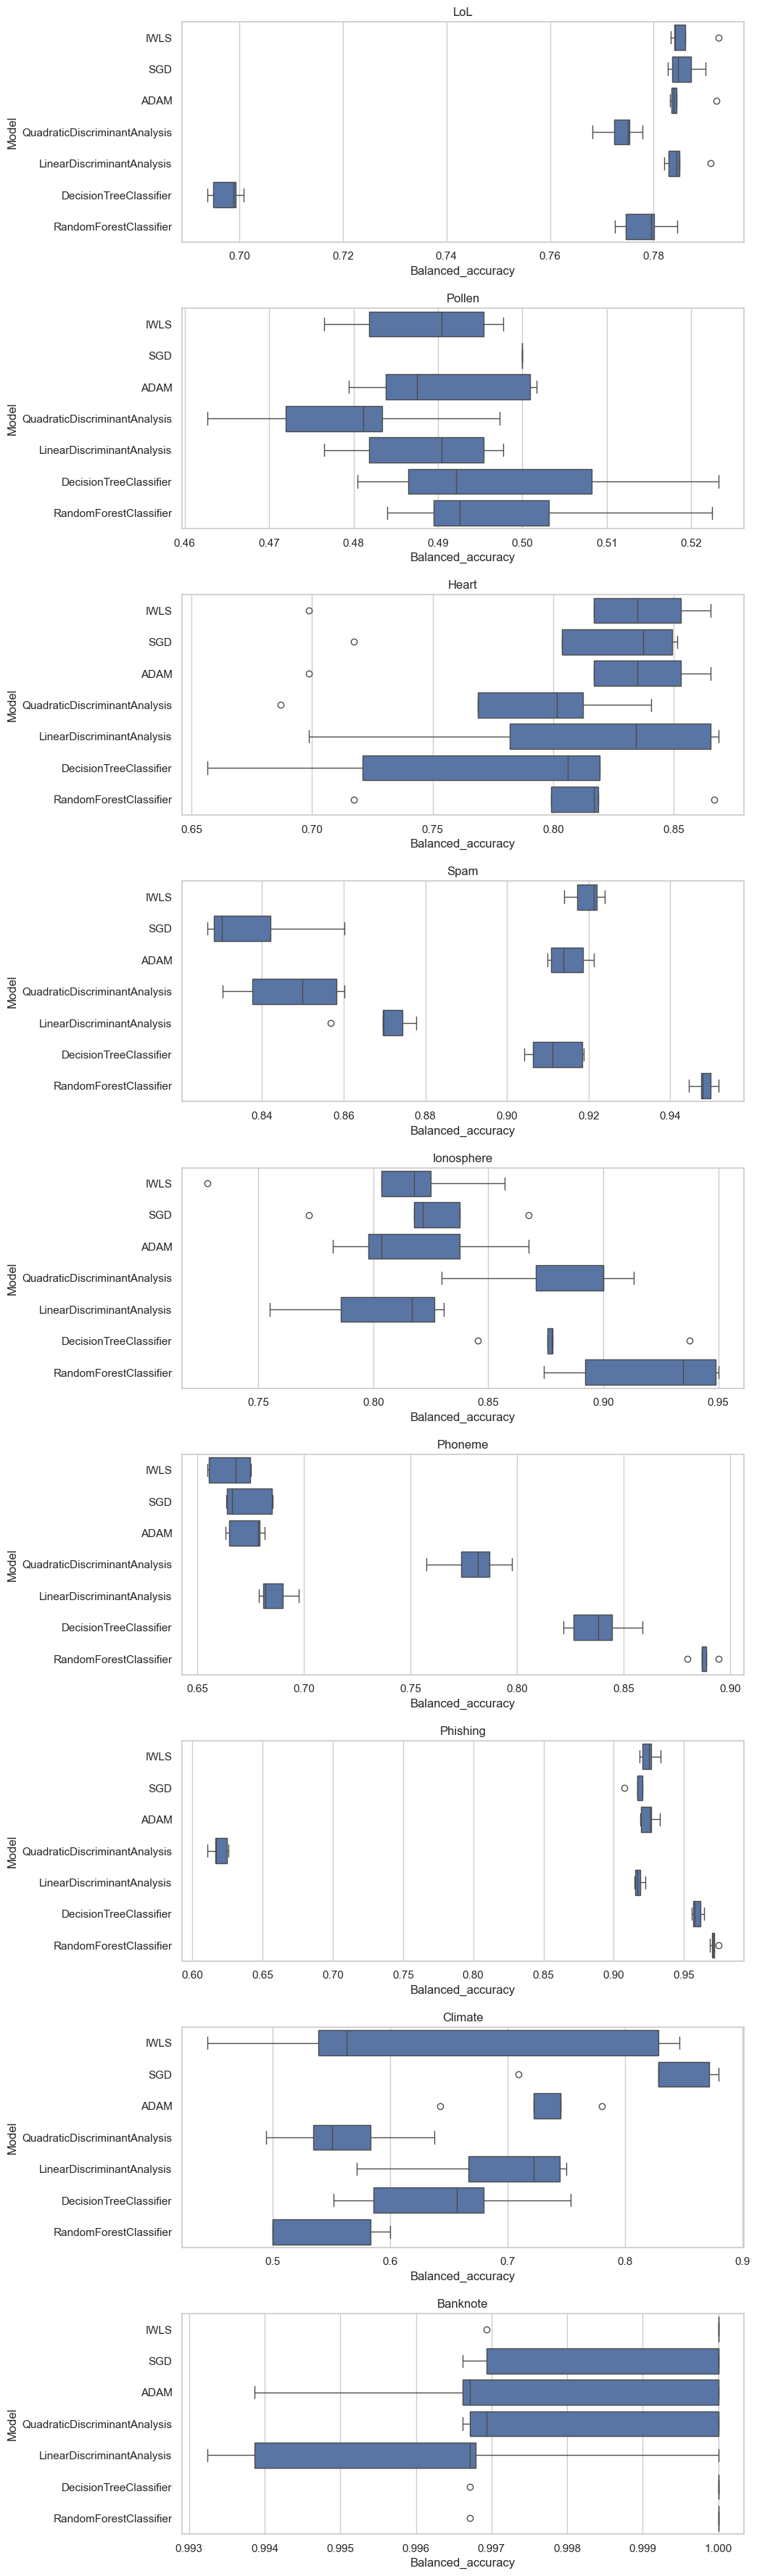

In [37]:
row_num = len(datasets)
sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(nrows=row_num, figsize=(10, 5 * row_num))
plt.subplots_adjust(hspace=0.3)
for i in range(row_num):
    dataset_name = datasets[i][2]
    dataset_results = results[results.Dataset == dataset_name]
    sns.boxplot(data=dataset_results, y='Model', x='Balanced_accuracy', ax=axs[i])
    axs[i].title.set_text(dataset_name)
plt.show()

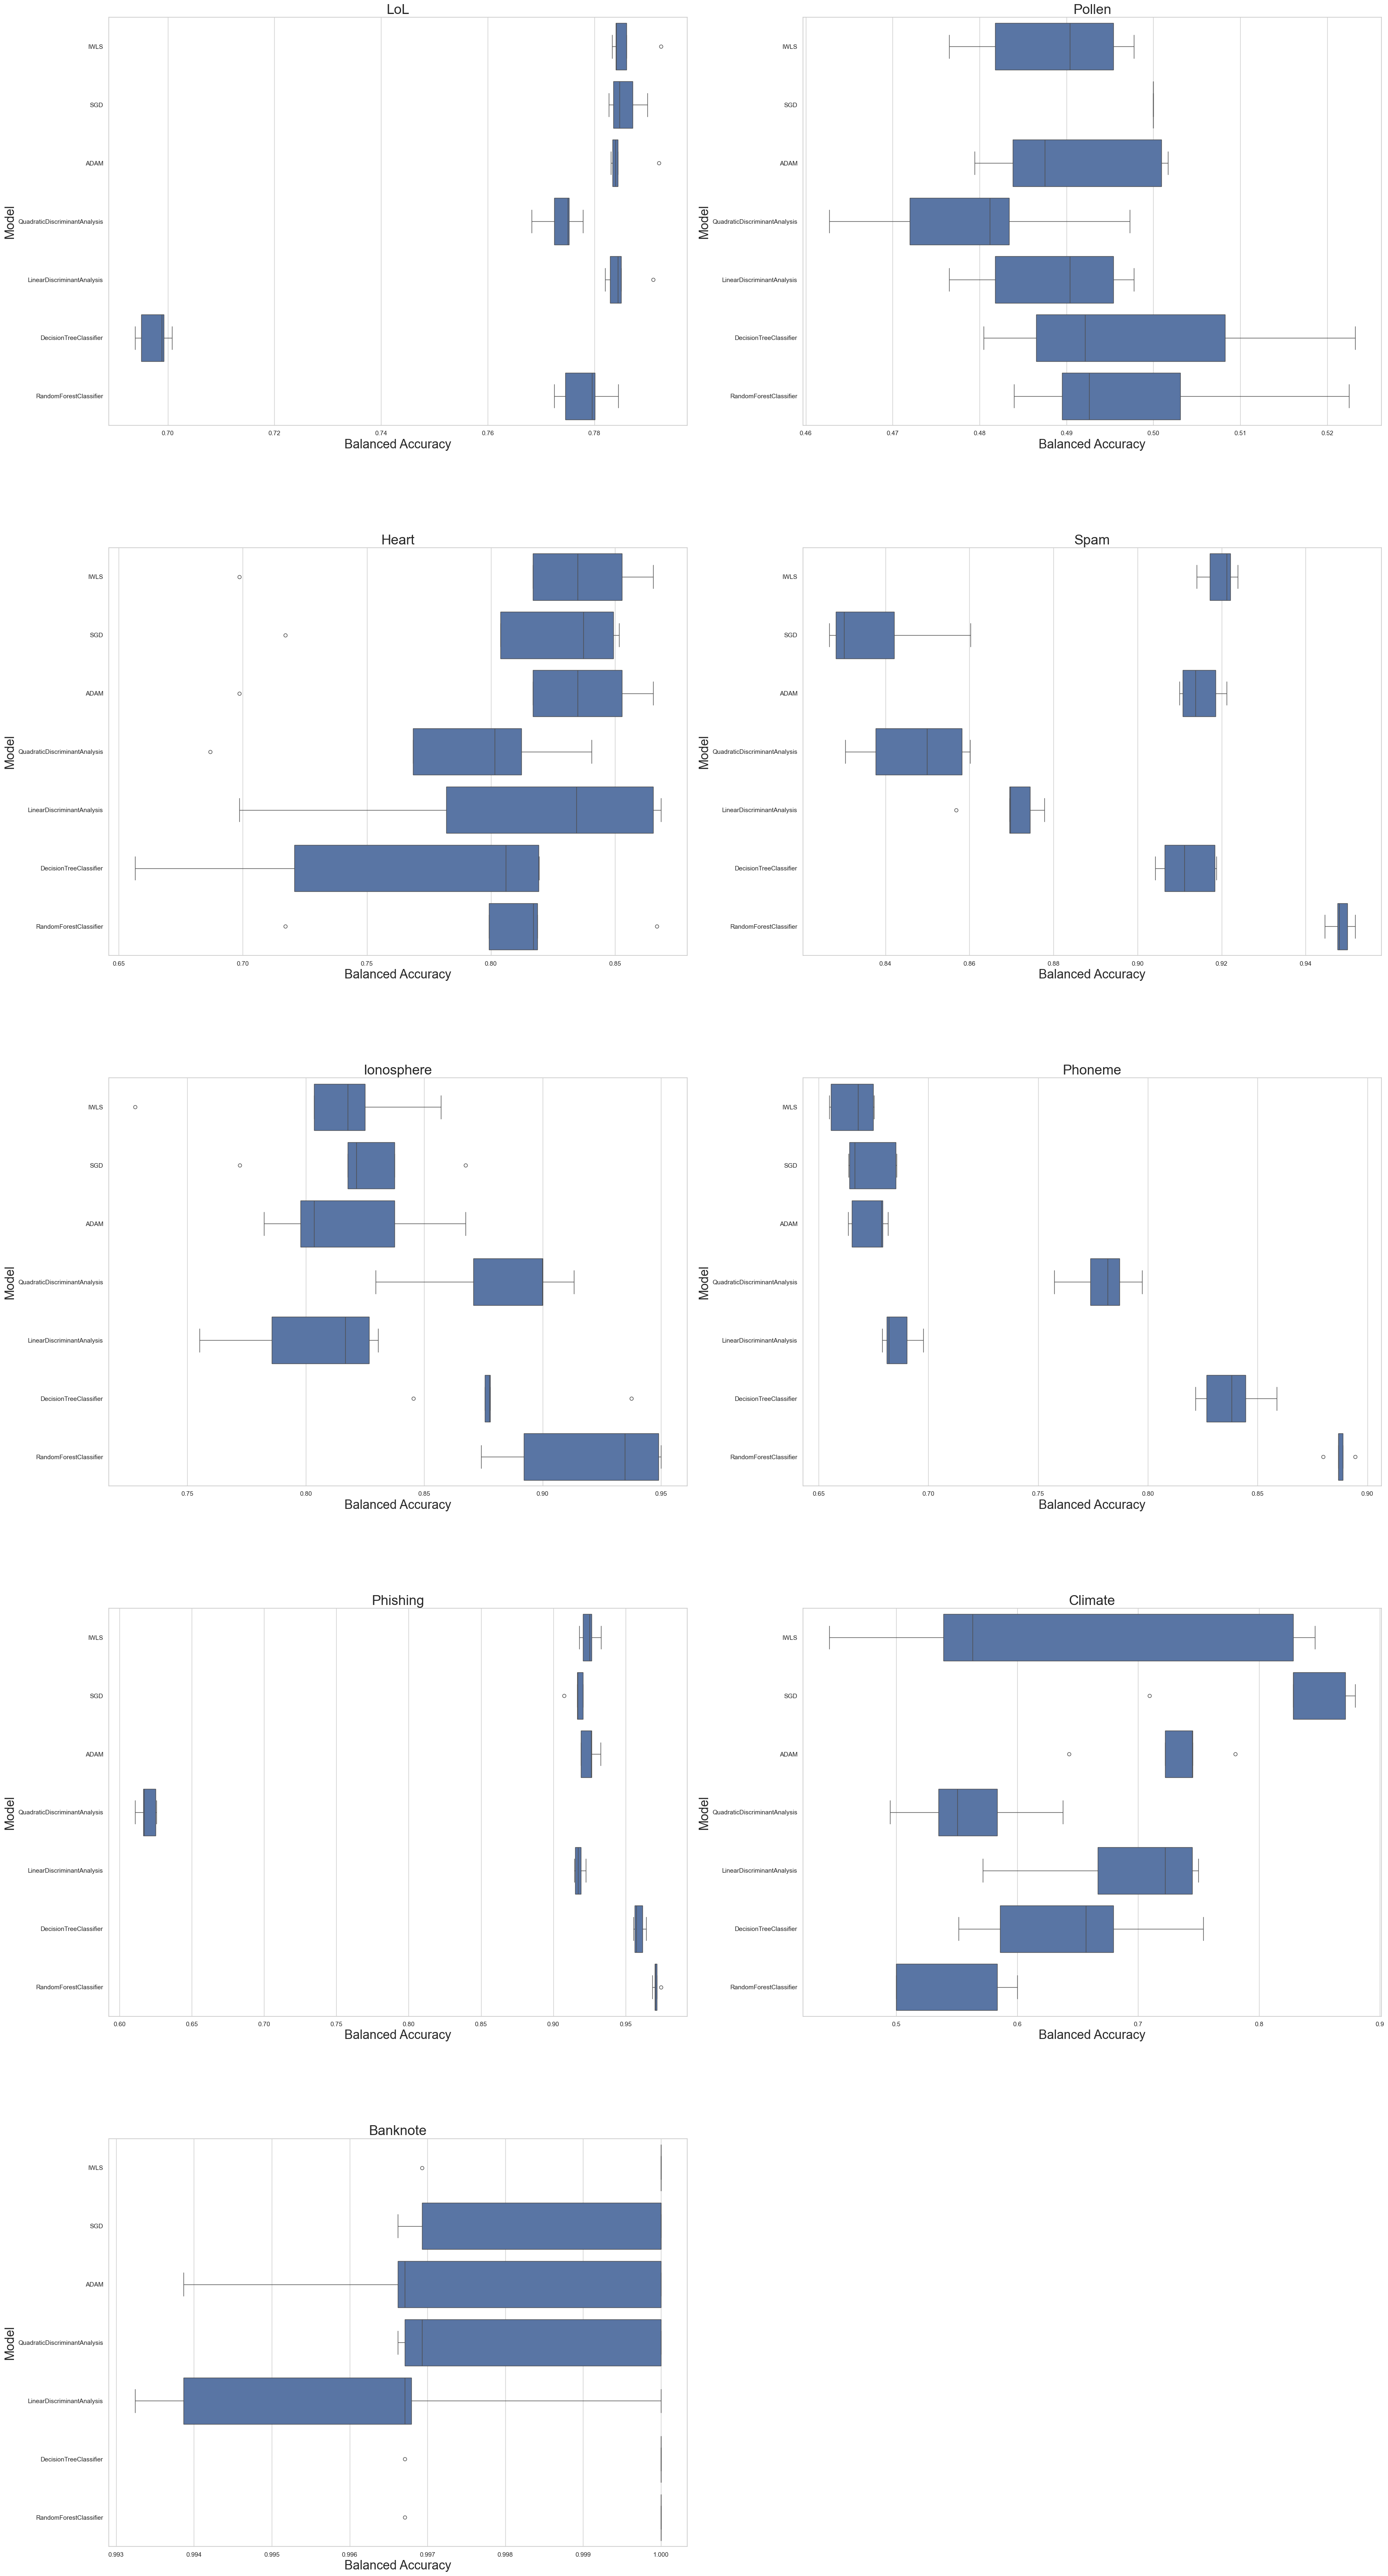

In [39]:
row_num = len(datasets) // 2 + (1 if len(datasets) % 2 != 0 else 0)
col_num = 2

sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(nrows=row_num, ncols=col_num, figsize=(20*col_num, 16 * row_num))
plt.subplots_adjust(hspace=0.3)

# Flatten axs if needed
if row_num == 1:
    axs = axs.reshape(1, -1)
elif col_num == 1:
    axs = axs.reshape(-1, 1)

for i in range(len(datasets)):
    dataset_name = datasets[i][2]
    dataset_results = results[results.Dataset == dataset_name]
    
    # Calculate subplot position
    row_idx = i // col_num
    col_idx = i % col_num
    
    # Plot on the corresponding subplot
    sns.boxplot(data=dataset_results, y='Model', x='Balanced_accuracy', ax=axs[row_idx, col_idx])
    axs[row_idx, col_idx].set_title(dataset_name)

if len(datasets) % 2 != 0:
    fig.delaxes(axs[-1, -1])

plt.savefig('classification_performance.png', format='png', bbox_inches='tight')

plt.show()

## Model without interactions VS model with interactions

In [48]:
def interactions(model_class, data, target, dataset_name, generate_interactions=False, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = {'Model': [model_class.__name__ + (' with interactions' if generate_interactions else '')] * n_splits,
               'Dataset': [dataset_name] * n_splits,
               'Balanced_accuracy': []}
    for train_idx, test_idx in kf.split(data):
        X_train = np.array(data.drop(columns=[target]).iloc[train_idx])
        y_train = np.array(data[target].iloc[train_idx])
        X_test = np.array(data.drop(columns=[target]).iloc[test_idx])
        y_test = np.array(data[target].iloc[test_idx])
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        model = model_class(generate_interactions=generate_interactions)
        model.train(X_train, y_train, 500)
        y_pred = model.predict(X_test)
        results['Balanced_accuracy'].append(balanced_accuracy_score(y_test, y_pred))
    
    return pd.DataFrame(results)

In [49]:
results = []

for data, target, name in small_datasets:    
    for model_class in MODEL_CLASSES:
        results.append(interactions(model_class, data, target, name))
        results.append(interactions(model_class, data, target, name, generate_interactions=True))

results = pd.concat(results)

IWLS Epoch 1/500 - loss: 0.6923830181962386
IWLS Epoch 2/500 - loss: 0.6923830162773433
IWLS Epoch 3/500 - loss: 0.6923830162773432
IWLS Epoch 4/500 - loss: 0.692383016277343
IWLS Epoch 5/500 - loss: 0.692383016277343
IWLS Epoch 6/500 - loss: 0.692383016277343
IWLS Epoch 7/500 - loss: 0.692383016277343
IWLS Epoch 8/500 - loss: 0.692383016277343
IWLS Epoch 9/500 - loss: 0.692383016277343
IWLS Epoch 10/500 - loss: 0.692383016277343
Early stopping
IWLS Epoch 1/500 - loss: 0.692703782747816
IWLS Epoch 2/500 - loss: 0.6927037824478869
IWLS Epoch 3/500 - loss: 0.692703782447887
IWLS Epoch 4/500 - loss: 0.692703782447887
IWLS Epoch 5/500 - loss: 0.692703782447887
IWLS Epoch 6/500 - loss: 0.692703782447887
IWLS Epoch 7/500 - loss: 0.692703782447887
IWLS Epoch 8/500 - loss: 0.692703782447887
IWLS Epoch 9/500 - loss: 0.692703782447887
IWLS Epoch 10/500 - loss: 0.692703782447887
Early stopping
IWLS Epoch 1/500 - loss: 0.6926321987511723
IWLS Epoch 2/500 - loss: 0.6926321982603628
IWLS Epoch 3/500

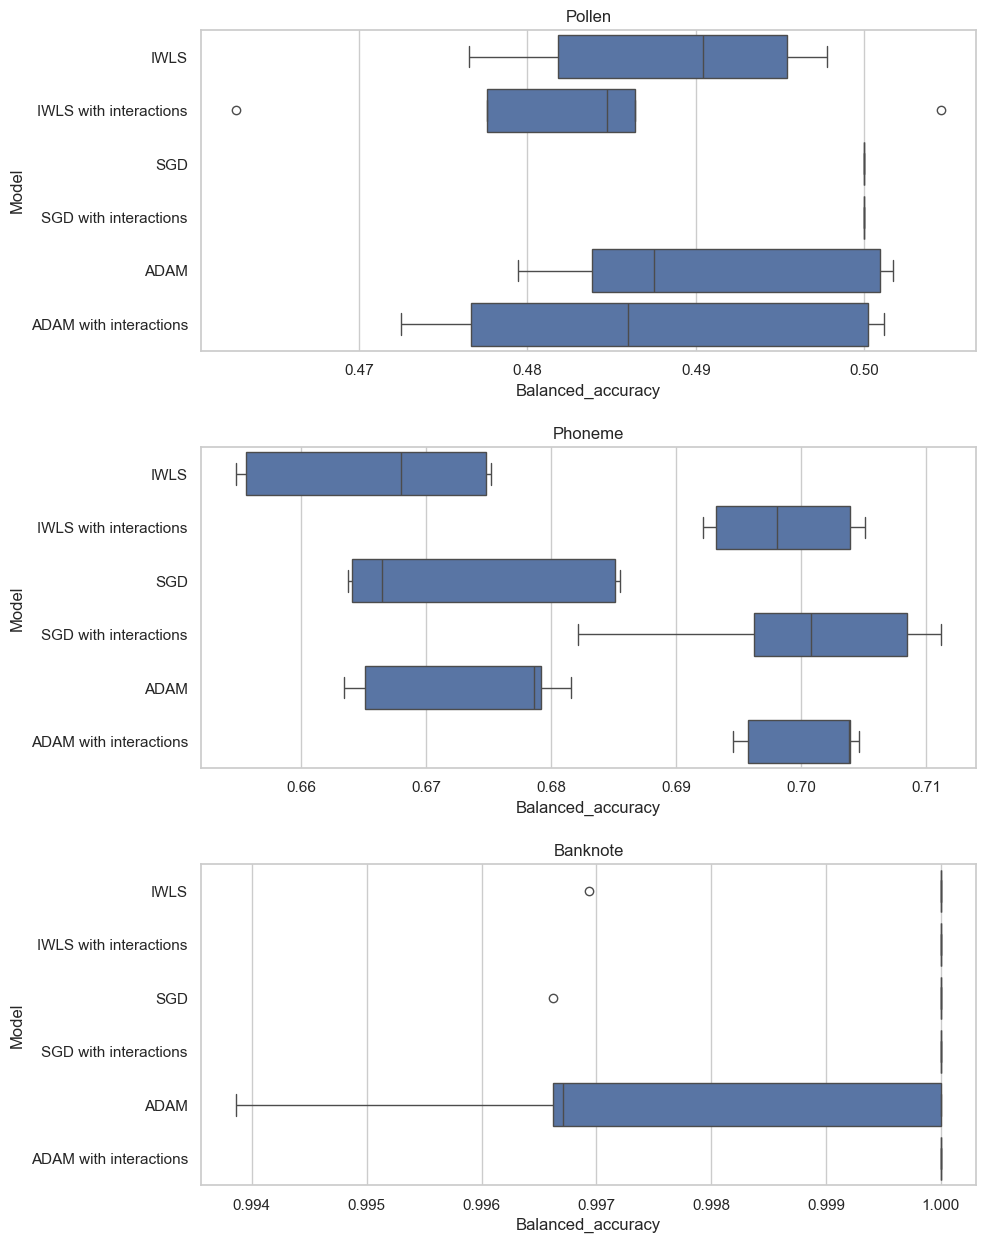

In [50]:
row_num = len(small_datasets)
sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(nrows=row_num, figsize=(10, 5 * row_num))
plt.subplots_adjust(hspace=0.3)
for i in range(row_num):
    dataset_name = small_datasets[i][2]
    dataset_results = results[results.Dataset == dataset_name]
    sns.boxplot(data=dataset_results, y='Model', x='Balanced_accuracy', ax=axs[i])
    axs[i].title.set_text(dataset_name)
plt.savefig('interactions.png', format='png', bbox_inches='tight')
plt.show()